In [3]:
# first import data 
#sshfs ascott47@jhu.edu@gateway2.marcc.jhu.edu:/scratch/groups/bzaitch1/badr/ mountpoint/
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import matplotlib.cm as cm
import scipy.spatial
import os 

#from netCDF4 import Dataset
#from wrf import getvar
#import wrf
#from wrf import ALL_TIMES
#### 

import scipy.stats
# define plots
def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind[ind].shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

from scipy.odr import Model, Data, ODR
from scipy.stats import linregress
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def easy_scatter_tls(x,y,title='', xlabel='', ylabel='', text_y_loc = .9 , text_x_loc = .5) : 
        linear = Model(f)
        ind = ~np.isnan(y) & ~np.isnan(x)
        linreg = scipy.stats.linregress(x[ind], y[ind])
        mydata = Data(x[ind], y[ind])
        myodr = ODR(mydata, linear, beta0=linreg[0:2]) # beta0 are initial guesses for paremeter values, ie, intercept and slope
        myoutput = myodr.run()
        # t-test for tls regression coeff
        DF = y[ind].shape[0] -2 # for a linear model
        b1 = myoutput.beta[0] # slope
        H0 = 1 # null hypothesis
        SE = myoutput.sd_beta[0]
        t = (b1-H0)/SE
        p = scipy.stats.t.cdf(t,df=DF)
        # plot it  
        plt.plot(x, f(myoutput.beta, x), 'k')
        plt.plot(np.linspace(x.min(), x.max(), 20),np.linspace(x.min(), x.max(), 20), '--k' )
        plt.scatter(x,y,color = 'grey', alpha =.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['y = %.2f x + %.2f'%(myoutput.beta[0], myoutput.beta[1]),
                    '1-1 line', 'Data'], loc=2, frameon =False)
        plt.title(title)
        return myoutput.beta[0], myoutput.beta[1],linreg.rvalue, p

plt.style.use('ggplot')
# read in temp data 
filepath = '../cityheat/Bmore/2016/'

meta = pd.DataFrame(pd.read_csv(filepath + 'data/CleanedMeta2016.csv', sep = ','))
meta = meta.set_index('sensornumber', drop = False)
meta = meta.set_index(meta.index.astype('float64'), drop = False)
#mean_temp = pd.read_csv('meantemp.csv', header=-1).rename(columns = {0: 'SensorNumber', 1:'MeanTemp'}).set_index('SensorNumber')
tempDF = pd.read_csv(filepath + 'data/CleanedTemp2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')#.first()
tempDF.columns = tempDF.columns.astype('int')

rhDF = pd.read_csv(filepath + 'data/CleanedRH2016.csv', parse_dates = [0]).set_index('Date').resample('H', how = 'first')
rhDF.columns = rhDF.columns.astype('int')

urban_sensor = 86 #97 # science center
rural_sensor = 4 #68 # darryn's house

# import data to classify dry days and wet days 
file =  'data/' + 'BWI'+ '.dbdmt'
synopticDF =  pd.read_table(file, sep = ' ', header =  None, parse_dates = [1])
synopticDF.columns = ['id','date', 'ssc']
synopticDF = synopticDF.set_index(synopticDF['date'])
synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
syn = synopticDF['ssc']['2016-06-01': '2016-09-15'].resample('D').mean()#[pd.PeriodIndex(UHI.index, freq = 'D')[0]:pd.PeriodIndex(UHI.index, freq = 'D')[-1]]

# import asos obs
date_parser = pd.core.tools.datetimes.to_datetime # pd.datetools.to_datetime
asos = pd.read_csv('data/mdASOS_summer_2016.csv', parse_dates = ['valid'], date_parser = date_parser).set_index('valid')
asos.columns = ['station', 't_f', 't_c', 'dew_f', 'dew_c']
# correct for local time
asos.index = asos.index- pd.Timedelta('04:00:00')

for column in ['t_f', 't_c', 'dew_f', 'dew_c']: 
    asos[column] = pd.to_numeric(asos[column],errors='coerce')
obs = pd.DataFrame(index = asos.resample('H').mean().index, columns = ['rural', 'urban'])
obs['urban'] =  asos[asos['station'] =='DMH']['t_c'].resample('H').mean()
obs['rural'] =  asos[asos['station'] =='BWI']['t_c'].resample('H').mean()

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:82: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:85: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
/Users/ascott47/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Subtract off science center bias

# Map (could also be spatial variability?) 

In [24]:
import cartopy.crs as ccrs

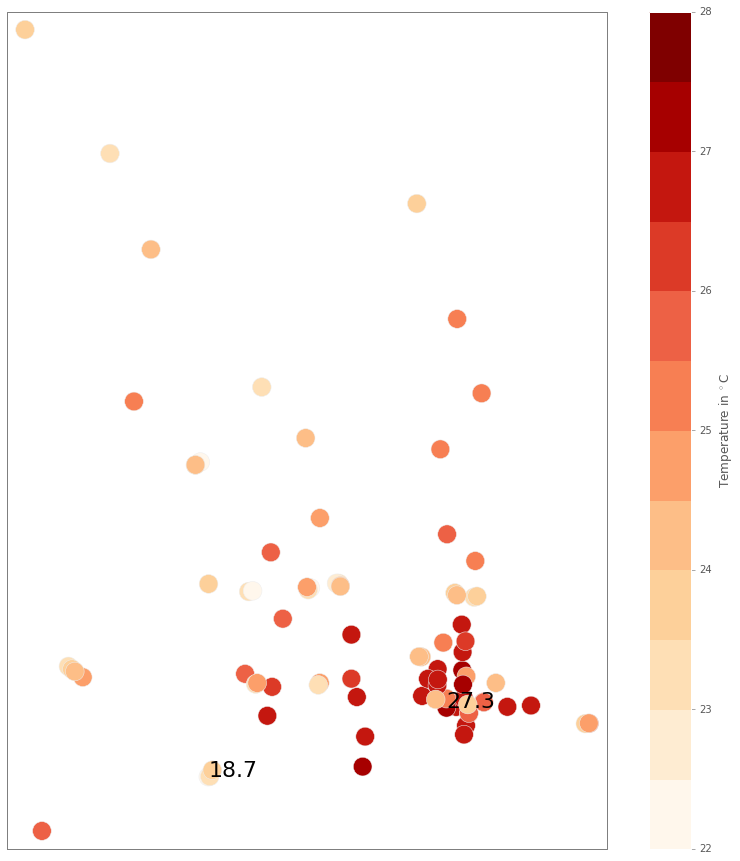

In [30]:
x = meta['location:Longitude'].values
y = meta['location:Latitude'].values
c = tempDF.mean(axis=0)
marker_size = 350
fig = plt.figure(figsize=[15,15])
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(( meta['location:Longitude'].min()-.005,
               meta['location:Longitude'].max()+.005 ,
               meta['location:Latitude'].min()-.005,
               meta['location:Latitude'].max()+.005))

cmap = matplotlib.cm.OrRd
bounds = np.linspace(round((c.mean()-3)),round((c.mean()+3)),13)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
plotHandle = ax.scatter(x,y,c = c, s = marker_size, transform=ccrs.Geodetic(),
             cmap = cmap,
             norm = norm)

cbar1 = plt.colorbar(plotHandle, label = 'Temperature in $^\circ $C')
lon = x[np.nanargmax(c)]
lat = y[np.nanargmax(c)]
at_x, at_y = ax.projection.transform_point(lon, lat,
                                           src_crs=ccrs.Geodetic())
plt.annotate(
    '%2.1f'%np.nanmax(c.values), xy=(at_x, at_y), #xytext=(30, 20), textcoords='offset points',
    color='black', backgroundcolor='none', size=22,
    )

lon = x[np.nanargmin(c)]
lat = y[np.nanargmin(c)]
at_x, at_y = ax.projection.transform_point(lon, lat,
                                           src_crs=ccrs.Geodetic())
plt.annotate(
    '%2.1f'%np.nanmin(c.values), xy=(at_x, at_y), #xytext=(30, 20), textcoords='offset points',
    color='black', size = 22, backgroundcolor='none')

In [31]:
# would be helpful to have this as a plotly object

In [32]:
sci_center = 97
urbn_park = 32
north_city = 85
rural = 68
selected = [97,32,85,68]

# Diurnal cycle 

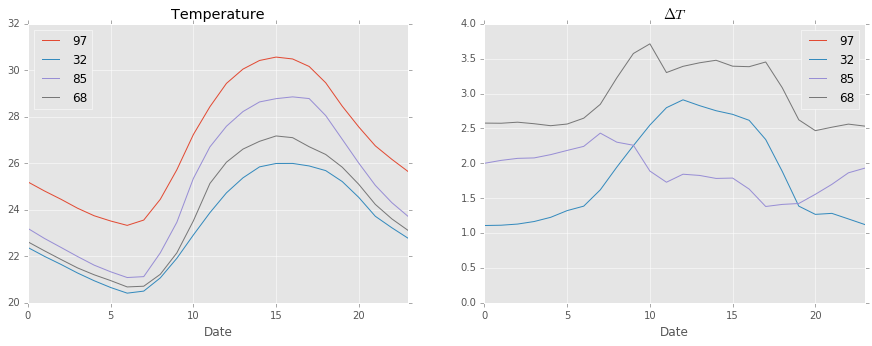

In [51]:
plt.figure(figsize = [15,5])
#plot temp
ax = plt.subplot(1,2,1)
tempDF[selected].groupby(tempDF.index.hour).mean().plot(ax=ax)
ax.set_title('Temperature')
# plot DT
ax = plt.subplot(1,2,2)
(tempDF*-1).add(tempDF[97], axis=0).groupby(tempDF.index.hour).mean()[selected].plot(ax=ax)
ax.set_title('$\Delta T$')

# UHI intensity as a function of distance from the city center

http://connor-johnson.com/2014/03/20/simple-kriging-in-python/

No location data for 131
No location data for 143
No location data for 120
No location data for 109
No location data for 136


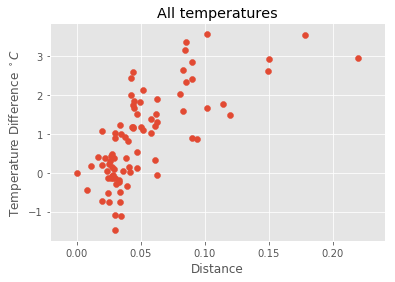

In [33]:
variogram = pd.DataFrame(columns=['Distance', 'Difference'], index = meta.index)
city_center =[meta.loc[97, 'location:Longitude'], meta.loc[97, 'location:Latitude']]
for sel in meta.index.astype(int):
    try : 
        variogram.loc[sel, 'Distance'] = scipy.spatial.distance.euclidean(city_center, [meta.loc[sel, 'location:Longitude'], meta.loc[sel, 'location:Latitude']])
        variogram.loc[sel, 'Difference'] = tempDF[97].subtract(tempDF[sel]).mean()
    except ValueError: 
        print('No location data for %s'%sel)
        
plt.scatter(variogram['Distance'], variogram['Difference'])

plt.xlabel('Distance')
plt.ylabel('Temperature Difference $^\circ C$')
plt.title('All temperatures')

No location data for 131
No location data for 143
No location data for 120
No location data for 109
No location data for 136


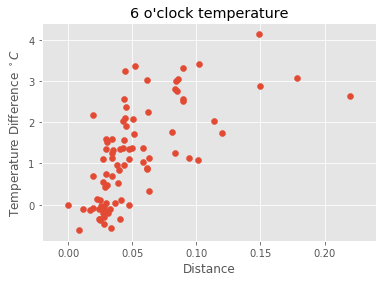

In [37]:
hr = 6
variogram = pd.DataFrame(columns=['Distance', 'Difference'], index = meta.index)
city_center =[meta.loc[97, 'location:Longitude'], meta.loc[97, 'location:Latitude']]
for sel in meta.index.astype(int):
    try : 
        variogram.loc[sel, 'Distance'] = scipy.spatial.distance.euclidean(city_center, [meta.loc[sel, 'location:Longitude'], meta.loc[sel, 'location:Latitude']])
        variogram.loc[sel, 'Difference'] = tempDF[97].subtract(tempDF[sel])[tempDF.index.hour==hr].mean()
    except ValueError: 
        print('No location data for %s'%sel)
        
plt.scatter(variogram['Distance'], variogram['Difference'])

plt.xlabel('Distance')
plt.ylabel('Temperature Difference $^\circ C$')
plt.title('%i o\'clock temperature'%hr)

No location data for 131
No location data for 143
No location data for 120
No location data for 109
No location data for 136


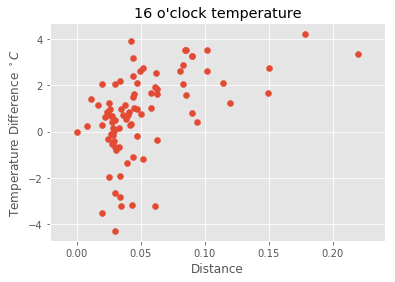

In [38]:
hr = 16
variogram = pd.DataFrame(columns=['Distance', 'Difference'], index = meta.index)
city_center =[meta.loc[97, 'location:Longitude'], meta.loc[97, 'location:Latitude']]
for sel in meta.index.astype(int):
    try : 
        variogram.loc[sel, 'Distance'] = scipy.spatial.distance.euclidean(city_center, [meta.loc[sel, 'location:Longitude'], meta.loc[sel, 'location:Latitude']])
        variogram.loc[sel, 'Difference'] = tempDF[97].subtract(tempDF[sel])[tempDF.index.hour==hr].mean()
    except ValueError: 
        print('No location data for %s'%sel)
        
plt.scatter(variogram['Distance'], variogram['Difference'])

plt.xlabel('Distance')
plt.ylabel('Temperature Difference $^\circ C$')
plt.title('%i o\'clock temperature'%hr)

# Variability within city

We need to know: how does temp vary with landcover type, what is the average difference between two points

# Change during warmer periods